In [1]:
# ! ls -al /data/s3-cache/foba_events/hk/stocks_dremio/

In [2]:
# !pip install --upgrade --force-reinstall --no-deps git+ssh://git@gitlab.trading.imc.intra/apac-analysis/underlying-analysis

In [1]:
from imc_util.contrib.fullorderbook.new_enrichers.persist import s3_pull
from imc_util.contrib.fullorderbook.s3_wrappers.hk_stocks import get_days_ago
from imc_util.contrib.hk.hk_stocks_foba_util import enrich_hk_stocks_foba_dataframe_general_fields, enrich_hk_stocks_foba_dataframe_competitors
from imc_util.core.pandas_util import DataFrameReport
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

/opt/conda/envs/hk-hedging-shared/lib/python3.8/site-packages/imc_util/core/_pivot.py:8: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import MultiIndex, Index


In [2]:
import datetime
from IPython.display import HTML
import IPython.display as iDisp
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '{:15,.12g}'.format(float('{:.3}'.format(float(x)))))

plt.rcParams['figure.figsize'] = (25, 5)

style = """
<style>
.container { width:90% !important; }
</style>
"""
HTML(style)

In [3]:
days_ago = get_days_ago()

In [4]:
num_days = 1

In [5]:
raw_data = s3_pull(desk='hk', strategies=['stocks_dremio'], days_ago=days_ago, num_days=num_days, max_tries=3)

2024-03-10 16:42:19,134 - imc_util.contrib.fullorderbook.new_enrichers.persist - DEBUG - s3_pull_dates(strategies=[stocks_dremio], dates=[20240307]): Started
2024-03-10 16:42:21,074 - imc_util.core.aws - DEBUG - Starting download from S3 for key foba_events/hk/stocks_dremio/20240307.h5
2024-03-10 16:42:28,884 - imc_util.core.aws - DEBUG - Finished download from S3 for key foba_events/hk/stocks_dremio/20240307.h5
2024-03-10 16:42:48,990 - imc_util.contrib.fullorderbook.new_enrichers.persist - DEBUG - s3_pull_dates: Completed


In [8]:
raw_data['volume_after_join_bbov_fraction'].isnull()

0         True
1         True
2         True
3         True
4         True
          ... 
991819    True
991820    True
991821    True
991822    True
991823    True
Name: volume_after_join_bbov_fraction, Length: 991824, dtype: bool

In [11]:
raw_data[[c for c in raw_data.columns if 'bbov' in c.lower()]]

,BBOV_at_join,BBOV_at_event,aggressor_volume_bbov_fraction,volume_after_join_bbov_fraction,volume_ahead_at_join_bbov_fraction,join_volume_bbov_fraction,event_volume_bbov_fraction,remaining_volume_bbov_fraction
0,"4,730","4,730",None,None,None,None,None,None
1,"4,730","4,730",None,None,None,None,None,None
2,"4,730","4,730",None,None,None,None,None,None
3,"4,730","4,730",None,None,None,None,None,None
4,"50,000","50,000",None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
991819,"19,300","18,100",None,None,None,None,None,None
991820,"19,200","18,100",None,None,None,None,None,None
991821,"10,800,000","10,600,000",None,None,None,None,None,None
991822,"10,800,000","10,600,000",None,None,None,None,None,None


In [6]:
# raw_data = enrich_hk_stocks_foba_dataframe(raw_data, enrich_peak_percents=False)
raw_data = enrich_hk_stocks_foba_dataframe_general_fields(raw_data)
raw_data = enrich_hk_stocks_foba_dataframe_competitors(raw_data)

In [7]:
trade_data = DataFrameReport(raw_data[raw_data.event_type == 'TRADE'].copy())

In [8]:
del raw_data

In [9]:
# pull_data = DataFrameReport(raw_data[raw_data.event_type == 'DELETE'].copy())

In [10]:
trade_data.broker_number = np.where(np.logical_and(trade_data.competitor == 'IMC', ~trade_data.broker_number.isin([1453, 765, 763, 1045, 748, 1450, 1049, 1048, 747, 746, 769, 764, 766])), 0, trade_data.broker_number)

In [11]:
trade_data['aggressive_competitor'] = np.where((trade_data.aggressive_competitor == 'IMC') & (trade_data.imc_auto_trader.str.contains('Bsk_Exe')), 'IMC_BSK', trade_data['aggressive_competitor'])

In [12]:
trade_data['hour'] = trade_data['event_time_from_start_of_day_second'] // 3600
trade_data['minute'] = (trade_data['event_time_from_start_of_day_second'] - trade_data['hour'] * 3600) // 60

In [13]:
sectors = {'AAC': 'tech', 'ABC': 'banks', 'ACC': 'construction', 'AIA': 'insurers', 'ALB': 'tech', 'ALC': 'mining', 'ALH': 'tech', 'ANA': 'consumer', 
           'BCL': 'banks', 'BCM': 'banks', 'BIU': 'tech', 'BLI': 'tech', 'BOC': 'banks', 'BUD': 'consumer', 'BYD': 'auto', 'BYE': 'tech', 
           'CCB': 'banks', 'CCC': 'construction', 'CHT': 'telco', 'CHU': 'telco', 'CKH': 'properties', 'CKP': 'properties', 'CLI': 'insurers', 
           'CLP': 'utilities', 'CMB': 'banks', 'CNC': 'oils', 'COG': 'properties', 'COL': 'properties', 'COS': 'consumer', 'CPC': 'oils', 
           'CPI': 'insurers', 'CRL': 'properties', 'CSE': 'mining', 'CSP': 'pharma', 'CTB': 'banks', 'CTC': 'telco', 'CTS': 'markets', 
           'EVG': 'properties', 'GAH': 'auto', 'GHL': 'construction', 'GLI': 'mining', 'GLX': 'casinos', 'GWM': 'auto', 'HAI': 'markets', 
           'HDO': 'consumer', 'HEH': 'utilities', 'HEX': 'markets', 'HGN': 'consumer', 'HKB': 'banks', 'HKG': 'utilities', 'HLD': 'properties', 
           'HSB': 'banks', 'ICB': 'banks', 'JDC': 'tech', 'JDH': 'tech', 'JXC': 'mining', 'KDS': 'tech', 'KSO': 'tech', 'KST': 'tech', 
           'LAU': 'auto', 'LEN': 'tech', 'LNI': 'consumer', 'LNK': 'properties', 'MEN': 'consumer', 'MET': 'tech', 'MIU': 'tech', 'MOL': 'mining', 
           'MSB': 'banks', 'MTR': 'properties', 'NBM': 'construction', 'NCL': 'insurers', 'NFU': 'consumer', 'NTE': 'tech', 'NWD': 'properties', 
           'PAI': 'insurers', 'PEC': 'oils', 'PEN': 'auto', 'PHT': 'tech', 'PIC': 'insurers', 'SAN': 'casinos', 'SBO': 'consumer', 'SHK': 'properties', 
           'SHL': 'utilities', 'SHZ': 'consumer', 'SMC': 'tech', 'SNO': 'tech', 'SUN': 'properties', 'TCH': 'tech', 'TIC': 'consumer', 'TRP': 'tech', 
           'TWR': 'telco', 'VNK': 'properties', 'WHL': 'properties', 'WXB': 'pharma', 'XPB': 'banks', 'YZC': 'mining', 'ZAO': 'insurers'}
trade_data['sector'] = trade_data['product_symbol'].map(sectors)

In [14]:
HTML(f'<H1>HK Stocks Hedging - ABN vs IMC: {trade_data.date.max()}</H1>')

In [15]:
dates = list(trade_data['date'].unique())
iDisp.display(HTML("<H2>Dates Included:</H2>"))
for date in dates:
    iDisp.display(HTML("<p>" + str(date) + "</p>"))

In [16]:
end_prices = trade_data.groupby(['date', 'product_symbol'])[['event_price']].last().to_dict()['event_price']

def get_end_price(date, symbol):
    return end_prices[(date, symbol)]

trade_data['currency_rate'] = trade_data['turnover'] / (trade_data['event_volume'] * trade_data['event_price'])
trade_data['eod_price'] = trade_data[['date', 'product_symbol']].apply(lambda x: get_end_price(x['date'], x['product_symbol']), axis=1)

In [17]:
trade_data['eod_price'] = trade_data[['date', 'product_symbol']].apply(lambda x: get_end_price(x['date'], x['product_symbol']), axis=1)

In [18]:
trade_data['slipped_pnl_eod'] = np.where(trade_data['side'] == 'BID', 
                                         (trade_data['eod_price'] - trade_data['event_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'], 
                                        (trade_data['event_price'] - trade_data['eod_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'])
trade_data['aggressor_slipped_pnl_eod'] = np.where(trade_data['side'] == 'BID', 
                                                   (trade_data['event_price'] - trade_data['eod_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'], 
                                                   (trade_data['eod_price'] - trade_data['event_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'])

In [19]:
def display_table(data, index, group_broker=False, aggressive=False, sort_by='slipped_pnl_120s', ascending=False, max_rows=10):
    data.reset()
    column_prefix = 'aggressor_' if aggressive else ''
    broker = 'foreign_counterparty' if aggressive else 'broker_name'
    sell_condition = data.direction > 0 if aggressive else data.direction < 0
    buy_condition = data.direction < 0 if aggressive else data.direction > 0
    
    if group_broker:
        temp = data.group_row(broker).group_row(index).sum(f'{column_prefix}slipped_pnl_0s').sum(f'{column_prefix}slipped_pnl_60s').sum(f'{column_prefix}slipped_pnl_120s').sum(f'{column_prefix}slipped_pnl_300s').sum(
            f'{column_prefix}slipped_pnl_900s').sum(f'{column_prefix}slipped_pnl_eod').sum('turnover').fast_report()
        total_turnover = temp.loc[('All', ''), 'turnover']
        
        temp_sell = data.distill(sell_condition).group_row(broker).group_row(index).sum('turnover', name='sell_turnover').fast_report()
        temp_buy = data.distill(buy_condition).group_row(broker).group_row(index).sum('turnover', name='buy_turnover').fast_report()
    else:
        temp = data.group_row(index).sum(f'{column_prefix}slipped_pnl_0s').sum(f'{column_prefix}slipped_pnl_60s').sum(f'{column_prefix}slipped_pnl_120s').sum(f'{column_prefix}slipped_pnl_300s').sum(
            f'{column_prefix}slipped_pnl_900s').sum(f'{column_prefix}slipped_pnl_eod').sum('turnover').fast_report()
        total_turnover = temp.loc['All', 'turnover']
        temp_sell = data.distill(sell_condition).group_row(index).sum('turnover', name='sell_turnover').fast_report()
        temp_buy = data.distill(buy_condition).group_row(index).sum('turnover', name='buy_turnover').fast_report()
    temp = pd.concat([temp, temp_buy, temp_sell], axis=1).fillna(value=0)
    temp['mkt%'] = temp['turnover'] / total_turnover * 100
    temp['bps_pnl_120s'] = temp[f'{column_prefix}slipped_pnl_120s'] / temp['turnover'] * 10000
    temp['bps_pnl_900s'] = temp[f'{column_prefix}slipped_pnl_900s'] / temp['turnover'] * 10000
    
    for i in ['UNKNOWN', 'MKT', 'All']:
        if i in temp.index:
            temp.drop(i, inplace=True)
    temp = temp.sort_values(sort_by, ascending=ascending).head(max_rows)
    iDisp.display(temp.heatmap(cols=slice(0, 6), buffer=1.5).heatmap(cols=slice(6, 9), cmap='RdBu', buffer=1.5).heatmap(cols=9, cmap='bwr', buffer=1.5).heatmap(cols=slice(10,12), cmap='BrBG', buffer=1.5, color_bounds=[0, None]).render_css())

In [20]:
iDisp.display(HTML("<H2>Competitor Summary</H2>"))
display_table(trade_data, index='aggressive_competitor',aggressive=True,sort_by='aggressor_slipped_pnl_120s')

,aggressor_slipped_pnl_0s,aggressor_slipped_pnl_60s,aggressor_slipped_pnl_120s,aggressor_slipped_pnl_300s,aggressor_slipped_pnl_900s,aggressor_slipped_pnl_eod,turnover,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_900s
aggressive_competitor,,,,,,,,,,,,
Citadel,"-74,000","48,100","58,900","74,300","106,000","175,000","75,100,000","23,500,000","51,500,000",1.06,7.84,14.1
IMC,"-27,600","47,300","44,700","42,400","89,100","173,000","260,000,000","125,000,000","135,000,000",3.66,1.72,3.42
Barclays,"-38,300","9,510","13,200","11,000","26,000","52,400","36,800,000","21,100,000","15,700,000",0.519,3.59,7.06
ABN,"-5,960",625,83.9,"1,610","5,950","14,500","7,170,000","3,710,000","3,460,000",0.101,0.117,8.3
IMC_BSK,-582,178,-87.3,-752,"-5,170","-18,400","2,120,000","2,070,000","56,500",0.0299,-0.411,-24.4
Optiver,"-3,070","-1,140","-2,460","-1,570","-1,930","-15,900","5,770,000","3,780,000","1,990,000",0.0812,-4.26,-3.34
Eclipse,"-6,250","-1,960","-3,510","-12,800","-17,100","-22,200","8,380,000","7,010,000","1,370,000",0.118,-4.19,-20.3


In [21]:
iDisp.display(HTML("<H3> Citadel Hit PNL by sector </H3>"))
display_table(trade_data[lambda x: x.aggressive_competitor=='Citadel'], index='sector',max_rows=100,aggressive=True,sort_by='aggressor_slipped_pnl_120s')

,aggressor_slipped_pnl_0s,aggressor_slipped_pnl_60s,aggressor_slipped_pnl_120s,aggressor_slipped_pnl_300s,aggressor_slipped_pnl_900s,aggressor_slipped_pnl_eod,turnover,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_900s
sector,,,,,,,,,,,,
banks,"-15,000","6,260","11,200","19,200","19,900","-14,000","13,300,000","7,330,000","6,020,000",29.2,8.36,14.9
properties,"-4,600","4,600","5,030","5,710","8,860","-14,100","4,440,000","3,290,000","1,150,000",9.72,11.3,19.9
consumer,"-3,900","1,120","1,970","2,700","2,640","8,530","4,210,000","2,400,000","1,810,000",9.22,4.68,6.25
pharma,"-1,930",966,"1,780","2,210","6,260","2,490","1,970,000","875,000","1,100,000",4.32,9.02,31.7
tech,"-7,520","1,840","1,590","4,780","2,940","13,100","9,780,000","6,080,000","3,700,000",21.4,1.63,3.01
casinos,"-1,880",821,595,"-1,300","-1,140","-13,200","2,050,000","1,650,000","399,000",4.49,2.9,-5.57
construction,-292,347,553,"1,110","1,090",880,"354,000","152,000","202,000",0.775,15.6,30.9
insurers,-662,391,358,804,"1,110","-3,190","1,090,000","873,000","213,000",2.38,3.3,10.2
markets,-365,659,309,705,65.9,515,"510,000","239,000","271,000",1.12,6.06,1.29


In [22]:
iDisp.display(HTML("<H3> Barclays Hit PNL by sector </H3>"))
display_table(trade_data[lambda x: x.aggressive_competitor=='Barclays'], index='sector',max_rows=100,aggressive=True,sort_by='aggressor_slipped_pnl_120s')

,aggressor_slipped_pnl_0s,aggressor_slipped_pnl_60s,aggressor_slipped_pnl_120s,aggressor_slipped_pnl_300s,aggressor_slipped_pnl_900s,aggressor_slipped_pnl_eod,turnover,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_900s
sector,,,,,,,,,,,,
oils,"-8,610","15,100","21,200","25,300","24,700","19,500","7,710,000","4,030,000","3,670,000",12.9,27.6,32.1
consumer,"-3,590","5,330","6,520","4,990","8,590","13,700","3,410,000","2,390,000","1,010,000",5.71,19.1,25.2
tech,"-11,600","4,360","3,090","10,700","9,150","14,100","12,100,000","8,700,000","3,430,000",20.3,2.55,7.54
auto,-878,"1,320","2,830","4,000","-2,020","-3,230","1,300,000","835,000","461,000",2.17,21.9,-15.6
utilities,"-1,050","1,780","1,860","1,540","2,220","1,910","965,000","606,000","359,000",1.62,19.3,22.9
construction,-821,164,"1,020","1,920","1,880","12,600","871,000",0,"871,000",1.46,11.7,21.5
markets,-807,779,"1,010","2,010",55.9,"-1,510","764,000","531,000","233,000",1.28,13.2,0.732
properties,"-3,590","1,110",522,-965,"-1,820",-561,"3,350,000","2,250,000","1,100,000",5.62,1.56,-5.44
telco,"-1,180",645,400,"1,960","2,510","2,500","1,730,000","620,000","1,110,000",2.9,2.31,14.5


In [23]:
iDisp.display(HTML("<H3> IMC Hit PNL by sector </H3>"))
display_table(trade_data[lambda x: x.aggressive_competitor=='IMC'], index='sector',max_rows=100,aggressive=True,sort_by='aggressor_slipped_pnl_120s')

,aggressor_slipped_pnl_0s,aggressor_slipped_pnl_60s,aggressor_slipped_pnl_120s,aggressor_slipped_pnl_300s,aggressor_slipped_pnl_900s,aggressor_slipped_pnl_eod,turnover,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_900s
sector,,,,,,,,,,,,
tech,"-13,600","46,400","47,300","30,100","50,700","-63,000","173,000,000","93,300,000","79,500,000",64.4,2.73,2.94
insurers,"-2,400","9,900","8,590",925,"-1,000","-2,800","15,500,000","8,150,000","7,340,000",5.77,5.55,-0.648
auto,"-3,380",-398,"7,130","7,440","5,970","15,200","21,700,000","10,800,000","10,900,000",8.08,3.29,2.75
oils,"-1,150","2,530","4,860","8,440","12,700","4,520","8,140,000","5,490,000","2,650,000",3.03,5.97,15.6
banks,-951,"3,980","4,130",351,"-3,010","-11,800","11,700,000","7,010,000","4,680,000",4.36,3.53,-2.57
consumer,"-1,760",834,"2,010","1,310","1,940","8,920","8,310,000","3,720,000","4,590,000",3.1,2.42,2.33
markets,-627,"1,390","1,350",-292,-627,"-9,190","6,890,000","4,060,000","2,820,000",2.57,1.97,-0.911
utilities,-129,433,556,231,-427,"-1,250","743,000","440,000","304,000",0.277,7.48,-5.75
properties,"-1,640",665,243,"-1,760","-4,040","-3,940","4,680,000","2,220,000","2,460,000",1.75,0.519,-8.62


In [24]:
iDisp.display(HTML("<H3> Citadel PNL by symbol</H3>"))
display_table(trade_data[lambda x: x.aggressive_competitor=='Citadel'], index='product_symbol',max_rows=50,aggressive=True,sort_by='aggressor_slipped_pnl_120s')

,aggressor_slipped_pnl_0s,aggressor_slipped_pnl_60s,aggressor_slipped_pnl_120s,aggressor_slipped_pnl_300s,aggressor_slipped_pnl_900s,aggressor_slipped_pnl_eod,turnover,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_900s
product_symbol,,,,,,,,,,,,
ICB,"-9,520","4,420","7,740","12,900","19,200","4,020","8,010,000","4,450,000","3,560,000",17.5,9.66,24
TCH,"-1,210","3,220","3,190","4,170","1,060","-7,670","2,470,000","2,470,000",0,5.39,12.9,4.27
CRL,"-1,040","2,540","2,990","3,450","9,190","-5,710","1,140,000","1,140,000",0,2.5,26.2,80.5
ABC,"-1,970","1,210","2,520","5,420","4,380","-7,190","1,650,000","1,050,000","597,000",3.59,15.3,26.6
CSP,"-1,280",814,"2,030","2,610","6,500","1,670","1,210,000","875,000","339,000",2.65,16.7,53.5
CMB,"-1,240","1,100","1,660","1,270","-3,120","-13,100","1,490,000","1,230,000","257,000",3.25,11.1,-21
SHZ,-682,"1,040","1,520","2,970","4,830","16,200","780,000","299,000","481,000",1.7,19.5,61.9
LAU,-591,"1,670","1,240",715,-683,"7,470","585,000","172,000","413,000",1.28,21.3,-11.7
NWD,"-1,160","1,200","1,130","1,540",226,"-4,780","734,000","541,000","193,000",1.6,15.4,3.08


In [25]:
iDisp.display(HTML("<H3> Barclays PNL by symbol</H3>"))
display_table(trade_data[lambda x: x.aggressive_competitor=='Barclays'], index='product_symbol',max_rows=50,aggressive=True,sort_by='aggressor_slipped_pnl_120s')

,aggressor_slipped_pnl_0s,aggressor_slipped_pnl_60s,aggressor_slipped_pnl_120s,aggressor_slipped_pnl_300s,aggressor_slipped_pnl_900s,aggressor_slipped_pnl_eod,turnover,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_900s
product_symbol,,,,,,,,,,,,
CPC,"-5,160","14,000","19,000","21,200","22,600","9,500","4,370,000","2,740,000","1,630,000",7.28,43.5,51.6
ANA,"-1,050","2,630","2,850","2,050","4,780","2,530","1,290,000","797,000","497,000",2.15,22,37
AAC,"-2,270","2,730","2,610","2,820","4,420","10,500","1,160,000","1,160,000",0,1.94,22.4,38
PEC,"-3,170",809,"2,210","3,440","1,180","4,350","3,060,000","1,060,000","2,010,000",5.1,7.22,3.86
HGN,-641,"1,250","1,910","1,490","1,030","2,030","376,000","208,000","168,000",0.627,50.7,27.3
GAH,-373,"1,090","1,850","1,710","-2,580","-8,950","582,000","582,000",0,0.969,31.8,-44.3
HKG,-472,"1,340","1,500","1,430","1,840","2,320","452,000","114,000","338,000",0.753,33.3,40.7
SAN,"-1,450","1,060","1,130",481,299,"-3,940","924,000","924,000",0,1.54,12.2,3.24
KSO,-341,"1,480","1,110","1,200","1,150","2,510","389,000","389,000",0,0.648,28.5,29.7


In [26]:
iDisp.display(HTML("<H3> IMC PNL by symbol</H3>"))
display_table(trade_data[lambda x: x.aggressive_competitor=='IMC'], index='product_symbol',max_rows=50,aggressive=True,sort_by='aggressor_slipped_pnl_120s')

,aggressor_slipped_pnl_0s,aggressor_slipped_pnl_60s,aggressor_slipped_pnl_120s,aggressor_slipped_pnl_300s,aggressor_slipped_pnl_900s,aggressor_slipped_pnl_eod,turnover,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_900s
product_symbol,,,,,,,,,,,,
ALB,-752,"18,200","24,200","17,800","21,400","-41,700","56,600,000","33,800,000","22,800,000",21,4.28,3.78
TCH,"-2,780","21,900","17,500","11,800","22,700","-3,440","63,200,000","31,000,000","32,200,000",23.4,2.76,3.59
BYD,"-2,580",468,"5,220","8,150","9,830","18,600","16,100,000","8,060,000","8,020,000",5.96,3.25,6.12
PAI,"-1,200","3,830","4,520",-119,"-3,660","-5,520","7,150,000","3,940,000","3,210,000",2.65,6.32,-5.12
CMB,-70.4,"3,210","4,020","4,370",606,"-9,050","2,010,000","1,400,000","613,000",0.746,20,3.01
AIA,"-1,040","5,290","3,420",874,"2,780","3,480","7,050,000","3,480,000","3,570,000",2.61,4.85,3.94
MIU,-474,"1,990","2,760","2,610","2,570","4,530","5,900,000","3,950,000","1,950,000",2.19,4.67,4.36
PEC,-111,"1,710","2,700","6,500","8,330","2,750","2,830,000","2,210,000","623,000",1.05,9.53,29.4
JDC,"-2,260","2,220","2,630","-3,210","2,290","-10,900","10,800,000","6,030,000","4,760,000",4,2.43,2.13


In [27]:
trade_data['book_width_at_event'] = trade_data['asks_0_price_at_event_'] - trade_data['bids_0_price_at_event_']
trade_data['book_width_at_join'] = trade_data['asks_0_price_at_join_'] - trade_data['bids_0_price_at_join_']
trade_data['ticks_wide_at_event'] = (trade_data['book_width_at_event'] / trade_data['tick_size']).round(0)
trade_data['ticks_wide_at_join'] = (trade_data['book_width_at_join'] / trade_data['tick_size']).round(0)

In [28]:
trade_data['ticks_wide_at_event_bucket'] = np.where(trade_data.ticks_wide_at_event == 1, '1', np.where(trade_data.ticks_wide_at_event == 2, '2', np.where(trade_data.ticks_wide_at_event > 2, '3+', '0')))
trade_data['ticks_wide_at_join_bucket'] = np.where(trade_data.ticks_wide_at_join == 1, '1', np.where(trade_data.ticks_wide_at_join == 2, '2', np.where(trade_data.ticks_wide_at_join > 2, '3+', '0')))

In [29]:
trade_data['level_clearing'] = trade_data['remaining_volume']==0

In [30]:
iDisp.display(HTML("<H2> Citadel/Barclays vs IMC Stats  various buckets </H3>"))

In [31]:
iDisp.display(HTML("<H3> PNL by number of ticks wide at event </H3>"))
a = trade_data[trade_data.aggressive_competitor.isin(['Citadel','Barclays','IMC'])].groupby(['aggressive_competitor','ticks_wide_at_event_bucket'])[
    ['turnover', 'aggressor_slipped_pnl_120s','aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s']].sum()

a['bps_120s'] = a['aggressor_slipped_pnl_120s'] / a['turnover'] * 10000
a['bps_300s'] = a['aggressor_slipped_pnl_300s'] / a['turnover'] * 10000
a['bps_900s'] = a['aggressor_slipped_pnl_900s'] / a['turnover'] * 10000
a

turnover  \
aggressive_competitor ticks_wide_at_event_bucket                   
Barclays              1                               54,500,000   
                      2                                5,140,000   
                      3+                                 405,000   
Citadel               1                               40,500,000   
                      2                                5,080,000   
                      3+                                 174,000   
IMC                   1                              268,000,000   
                      2                                  956,000   
                      3+                                 773,000   

                                                  aggressor_slipped_pnl_120s  \
aggressive_competitor ticks_wide_at_event_bucket                               
Barclays              1                                   32,400               
                      2                                    1,960               
                      3+                                     511               
Citadel               1                                   20,300               
                      2                                      952               
                      3+                                     510               
IMC                   1                                   72,900               
                      2                                    2,010               
                      3+                                    -462               

                                                  aggressor_slipped_pnl_300s  \
aggressive_competitor ticks_wide_at_event_bucket                               
Barclays              1                                   36,600               
                      2                                    3,690               
                      3+                                     779               
Citadel               1                                   22,200               
                      2                                      686               
                      3+                                     376               
IMC                   1                                   44,500               
                      2                                      639               
                      3+                                  -2,640               

                                                  aggressor_slipped_pnl_900s  \
aggressive_competitor ticks_wide_at_event_bucket                               
Barclays              1                                   30,500               
                      2                                    3,000               
                      3+                                   3,320               
Citadel               1                                   27,400               
                      2                                   -1,150               
                      3+                                     498               
IMC                   1                                   60,600               
                      2                                   -1,530               
                      3+                                  -5,250               

                                                        bps_120s  \
aggressive_competitor ticks_wide_at_event_bucket                   
Barclays              1                                     5.95   
                      2                                     3.81   
                      3+                                    12.6   
Citadel               1                                     5.02   
                      2                                     1.87   
                      3+                                    29.4   
IMC                   1                                     2.72   
                      2                             

In [32]:
iDisp.display(HTML("<H3> PNL by whether level clearing or not </H3>"))
a = trade_data[trade_data.aggressive_competitor.isin(['Citadel','Barclays','IMC'])].groupby(['aggressive_competitor','level_clearing'])[
    ['turnover', 'aggressor_slipped_pnl_120s','aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s']].sum()

a['bps_120s'] = a['aggressor_slipped_pnl_120s'] / a['turnover'] * 10000
a['bps_300s'] = a['aggressor_slipped_pnl_300s'] / a['turnover'] * 10000
a['bps_900s'] = a['aggressor_slipped_pnl_900s'] / a['turnover'] * 10000
a

turnover  \
aggressive_competitor level_clearing                   
Barclays              False                3,860,000   
                      True                56,200,000   
Citadel               False                1,710,000   
                      True                44,100,000   
IMC                   False               54,200,000   
                      True               216,000,000   

                                      aggressor_slipped_pnl_120s  \
aggressive_competitor level_clearing                               
Barclays              False                   -2,380               
                      True                    37,300               
Citadel               False                    1,010               
                      True                    20,800               
IMC                   False                   13,500               
                      True                    60,900               

                                      aggressor_slipped_pnl_300s  \
aggressive_competitor level_clearing                               
Barclays              False                   -1,220               
                      True                    42,200               
Citadel               False                    3,560               
                      True                    19,700               
IMC                   False                    5,750               
                      True                    36,700               

                                      aggressor_slipped_pnl_900s  \
aggressive_competitor level_clearing                               
Barclays              False                     -790               
                      True                    37,600               
Citadel               False                    5,460               
                      True                    21,300               
IMC                   False                      389               
                      True                    53,400               

                                            bps_120s        bps_300s  \
aggressive_competitor level_clearing                                   
Barclays              False                    -6.17           -3.16   
                      True                      6.63            7.51   
Citadel               False                     5.93            20.9   
                      True                      4.71            4.47   
IMC                   False                      2.5            1.06   
                      True                      2.82             1.7   

                                            bps_900s  
aggressive_competitor level_clearing                  
Barclays              False                    -2.05  
                      True                      6.69  
Citadel               False                     31.9  
                      True                      4.83  
IMC                   False                   0.0718  
                      True                      2.47

In [33]:
trade_data['aggressor_volume_bbov_fraction'] =  trade_data['aggressor_volume']/trade_data['BBOV_at_event'] 

In [34]:
iDisp.display(HTML("<H3> PNL by BBOV volume </H3>"))
a = trade_data[trade_data.aggressive_competitor.isin(['Citadel','Barclays','IMC'])].groupby(['aggressive_competitor',pd.cut(trade_data['aggressor_volume_bbov_fraction'],bins=[0,0.2,0.5,1,2,5])])[
    ['turnover', 'aggressor_slipped_pnl_120s','aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s']].sum()

a['bps_120s'] = a['aggressor_slipped_pnl_120s'] / a['turnover'] * 10000
a['bps_300s'] = a['aggressor_slipped_pnl_300s'] / a['turnover'] * 10000
a['bps_900s'] = a['aggressor_slipped_pnl_900s'] / a['turnover'] * 10000
a

turnover  \
aggressive_competitor aggressor_volume_bbov_fraction                   
Barclays              (0.0, 0.2]                           9,300,000   
                      (0.2, 0.5]                          13,400,000   
                      (0.5, 1.0]                          20,300,000   
                      (1.0, 2.0]                          14,400,000   
                      (2.0, 5.0]                           2,320,000   
Citadel               (0.0, 0.2]                           2,440,000   
                      (0.2, 0.5]                          16,000,000   
                      (0.5, 1.0]                          15,600,000   
                      (1.0, 2.0]                           9,730,000   
                      (2.0, 5.0]                           1,630,000   
IMC                   (0.0, 0.2]                         136,000,000   
                      (0.2, 0.5]                          87,900,000   
                      (0.5, 1.0]                          32,900,000   
                      (1.0, 2.0]                           9,150,000   
                      (2.0, 5.0]                           3,930,000   

                                                      aggressor_slipped_pnl_120s  \
aggressive_competitor aggressor_volume_bbov_fraction                               
Barclays              (0.0, 0.2]                              -5,840               
                      (0.2, 0.5]                               6,660               
                      (0.5, 1.0]                               6,530               
                      (1.0, 2.0]                              20,000               
                      (2.0, 5.0]                               5,720               
Citadel               (0.0, 0.2]                               1,740               
                      (0.2, 0.5]                               7,080               
                      (0.5, 1.0]                               6,050               
                      (1.0, 2.0]                               5,410               
                      (2.0, 5.0]                                 573               
IMC                   (0.0, 0.2]                              31,100               
                      (0.2, 0.5]                              36,900               
                      (0.5, 1.0]                              16,000               
                      (1.0, 2.0]                              -6,110               
                      (2.0, 5.0]                              -3,470               

                                                      aggressor_slipped_pnl_300s  \
aggressive_competitor aggressor_volume_bbov_fraction                               
Barclays              (0.0, 0.2]                              -5,290               
                      (0.2, 0.5]                               7,430               
                      (0.5, 1.0]                               5,440               
                      (1.0, 2.0]                              22,900               
                      (2.0, 5.0]                               8,690               
Citadel               (0.0, 0.2]                               2,690               
                      (0.2, 0.5]                               5,700               
                      (0.5, 1.0]                               7,930               
                      (1.0, 2.0]                               5,690               
                      (2.0, 5.0]                                 950               
IMC                   (0.0, 0.2]                              21,000               
                      (0.2, 0.5]                              26,300               
                      (0.5, 1.0]                              15,300               
                      (1.0, 2.0]                             -11,500               
                      (2.0, 5.0]                              

In [35]:
iDisp.display(HTML("<H3> Competitor PNL by unadjusted hit credit bps </H3>"))
a = trade_data[trade_data.aggressive_competitor.isin(['Citadel','Barclays'])].groupby(['aggressive_competitor',pd.cut(trade_data['aggressor_credit_at_max_event_sent_bps'],bins=[-100,-30,-20,-10,-7,-5,0,np.inf])])[
    ['turnover', 'aggressor_slipped_pnl_120s','aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s']].sum()

a['bps_120s'] = a['aggressor_slipped_pnl_120s'] / a['turnover'] * 10000
a['bps_300s'] = a['aggressor_slipped_pnl_300s'] / a['turnover'] * 10000
a['bps_900s'] = a['aggressor_slipped_pnl_900s'] / a['turnover'] * 10000
a

turnover  \
aggressive_competitor aggressor_credit_at_max_event_sent_bps                   
Barclays              (-100.0, -30.0]                                 77,800   
                      (-30.0, -20.0]                                 874,000   
                      (-20.0, -10.0]                              19,300,000   
                      (-10.0, -7.0]                               20,100,000   
                      (-7.0, -5.0]                                 9,570,000   
                      (-5.0, 0.0]                                  9,720,000   
                      (0.0, inf]                                     398,000   
Citadel               (-100.0, -30.0]                                 48,900   
                      (-30.0, -20.0]                                  20,100   
                      (-20.0, -10.0]                               8,820,000   
                      (-10.0, -7.0]                               15,500,000   
                      (-7.0, -5.0]                                 9,270,000   
                      (-5.0, 0.0]                                 11,600,000   
                      (0.0, inf]                                     587,000   

                                                              aggressor_slipped_pnl_120s  \
aggressive_competitor aggressor_credit_at_max_event_sent_bps                               
Barclays              (-100.0, -30.0]                                   -207               
                      (-30.0, -20.0]                                     956               
                      (-20.0, -10.0]                                  14,400               
                      (-10.0, -7.0]                                    5,550               
                      (-7.0, -5.0]                                     7,510               
                      (-5.0, 0.0]                                      6,150               
                      (0.0, inf]                                         553               
Citadel               (-100.0, -30.0]                                   18.3               
                      (-30.0, -20.0]                                  -0.493               
                      (-20.0, -10.0]                                   6,010               
                      (-10.0, -7.0]                                    5,700               
                      (-7.0, -5.0]                                     5,040               
                      (-5.0, 0.0]                                      4,400               
                      (0.0, inf]                                         622               

                                                              aggressor_slipped_pnl_300s  \
aggressive_competitor aggressor_credit_at_max_event_sent_bps                               
Barclays              (-100.0, -30.0]                                    -61               
                      (-30.0, -20.0]                                     502               
                      (-20.0, -10.0]                                  16,800               
                      (-10.0, -7.0]                                    7,000               
                      (-7.0, -5.0]                                    11,400               
                      (-5.0, 0.0]                                      5,190               
                      (0.0, inf]                                         237               
Citadel               (-100.0, -30.0]                                  -99.9               
                      (-30.0, -20.0]                                   -2.51               
                      (-20.0, -10.0]                                   8,680               
                      (-10.0, -7.0]                                    4,650               
                      (-7.0, -5.0]                                     6,040               
                      (-5.

In [36]:
iDisp.display(HTML("<H3> Competitor PNL by level age prior to hit </H3>"))
a = trade_data[trade_data.aggressive_competitor.isin(['Citadel','Barclays','IMC'])].groupby(['aggressive_competitor',pd.cut(trade_data['level_age_event_in_s'],bins=[0,5,30,60,120,240,900,round(max(trade_data[trade_data['aggressive_competitor'].isin(['Citadel','Barclays','IMC'])]['level_age_event_in_s']),0)])])[
    ['turnover', 'aggressor_slipped_pnl_120s','aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s']].sum()

a['bps_120s'] = a['aggressor_slipped_pnl_120s'] / a['turnover'] * 10000
a['bps_300s'] = a['aggressor_slipped_pnl_300s'] / a['turnover'] * 10000
a['bps_900s'] = a['aggressor_slipped_pnl_900s'] / a['turnover'] * 10000
a

turnover  \
aggressive_competitor level_age_event_in_s                   
Barclays              (0.0, 5.0]                 6,450,000   
                      (5.0, 30.0]                6,070,000   
                      (30.0, 60.0]               3,140,000   
                      (60.0, 120.0]              7,450,000   
                      (120.0, 240.0]             6,530,000   
                      (240.0, 900.0]            15,500,000   
                      (900.0, 21523.0]          14,900,000   
Citadel               (0.0, 5.0]                 4,090,000   
                      (5.0, 30.0]                5,260,000   
                      (30.0, 60.0]               6,590,000   
                      (60.0, 120.0]              6,330,000   
                      (120.0, 240.0]             4,980,000   
                      (240.0, 900.0]             7,670,000   
                      (900.0, 21523.0]          10,900,000   
IMC                   (0.0, 5.0]                37,900,000   
                      (5.0, 30.0]               33,300,000   
                      (30.0, 60.0]              20,000,000   
                      (60.0, 120.0]             24,000,000   
                      (120.0, 240.0]            37,300,000   
                      (240.0, 900.0]            64,800,000   
                      (900.0, 21523.0]          52,600,000   

                                            aggressor_slipped_pnl_120s  \
aggressive_competitor level_age_event_in_s                               
Barclays              (0.0, 5.0]                    -2,220               
                      (5.0, 30.0]                    7,180               
                      (30.0, 60.0]                  -1,940               
                      (60.0, 120.0]                 16,100               
                      (120.0, 240.0]                 2,330               
                      (240.0, 900.0]                 7,160               
                      (900.0, 21523.0]               6,300               
Citadel               (0.0, 5.0]                     4,500               
                      (5.0, 30.0]                    4,650               
                      (30.0, 60.0]                  -1,030               
                      (60.0, 120.0]                  5,700               
                      (120.0, 240.0]                 1,100               
                      (240.0, 900.0]                 2,540               
                      (900.0, 21523.0]               4,330               
IMC                   (0.0, 5.0]                    -4,760               
                      (5.0, 30.0]                   10,900               
                      (30.0, 60.0]                   3,850               
                      (60.0, 120.0]                  8,220               
                      (120.0, 240.0]                 9,740               
                      (240.0, 900.0]                29,300               
                      (900.0, 21523.0]              16,900               

                                            aggressor_slipped_pnl_300s  \
aggressive_competitor level_age_event_in_s                               
Barclays              (0.0, 5.0]                    -1,320               
                      (5.0, 30.0]                    7,850               
                      (30.0, 60.0]                  -1,710               
                      (60.0, 120.0]                 16,700               
                      (120.0, 240.0]                 5,990               
                      (240.0, 900.0]                 6,120               
                      (900.0, 21523.0]               7,390               
Citadel               (0.0, 5.0]                    10,100               
                      (5.0, 30.0]                    6,310               
                      (30.0, 60.0]                   3,640               
                      (60.0, 120

In [37]:
# iDisp.display(HTML("<H3> IMC PNL by adjustment triggered or not </H3>"))
# a = trade_data[trade_data.aggressive_competitor.isin(['IMC'])].groupby(['imc_hit_adjustment_triggered'])[
#     ['turnover', 'aggressor_slipped_pnl_120s','aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s']].sum()

# a['bps_120s'] = a['aggressor_slipped_pnl_120s'] / a['turnover'] * 10000
# a['bps_300s'] = a['aggressor_slipped_pnl_300s'] / a['turnover'] * 10000
# a['bps_900s'] = a['aggressor_slipped_pnl_900s'] / a['turnover'] * 10000
# a

In [38]:
def plot(data, index, values, values_right=None, filters=None, xlim=None, interval=None, columns=None,title=None):
    def create_pivot(data, index, values, filters):
        return pd.DataFrame(
            (data if not filters else data.loc[filters])
            .pipe(pd.pivot_table, index=index, values=(values if isinstance(values, list) else [values]), columns=columns, aggfunc='sum')
            .cumsum()
            .ffill()
        )
    
    df = create_pivot(data, index, values, filters)
    ax1 = df.plot(figsize=(20,6), grid=True,title=title)
    ax1.legend(loc='upper left')
    if xlim:
        ax1.set_xlim(xlim)
        if interval:
            ax1.set_xticks(range(xlim[0], xlim[1]+interval, interval))
    if values_right:
        ax2 = ax1.twinx()
        ax2.spines['right'].set_position(('axes', 1.0))
        create_pivot(data, index, values_right, filters).plot(ax=ax2, c='k').legend(loc='upper right')

In [39]:
trade_data['event_time_from_start_of_day_hours'] = trade_data['event_time_from_start_of_day_seconds'] / 3600

In [40]:
iDisp.display(HTML("<H2>Plots</H2>"))

In [41]:
iDisp.display(HTML("<H3> HSI by Time of Day</H3>"))

In [42]:
date = int(trade_data['date'].unique()[0].replace('-',''))

In [43]:
from imc.sail.sql import run_sql

In [44]:
query = f"""SELECT *, (FROM_UNIXTIME(timestampNanos_,'Asia/Hong_Kong')) as dt
                    FROM Sail.dart.IMCRetailState
                    WHERE date_id = {date}
                    AND deployment = 'p_au_fut_trad_hkfe02'
                    AND owner_ = 'ZAHSI'
                """

hsi_rs = run_sql('apac', query)

In [45]:
hsi_rs.sort_values('dt',inplace=True)

In [46]:
hsi_rs.set_index('dt',inplace=True)

In [47]:
hsi_rs = hsi_rs.between_time('09:30','16:00')

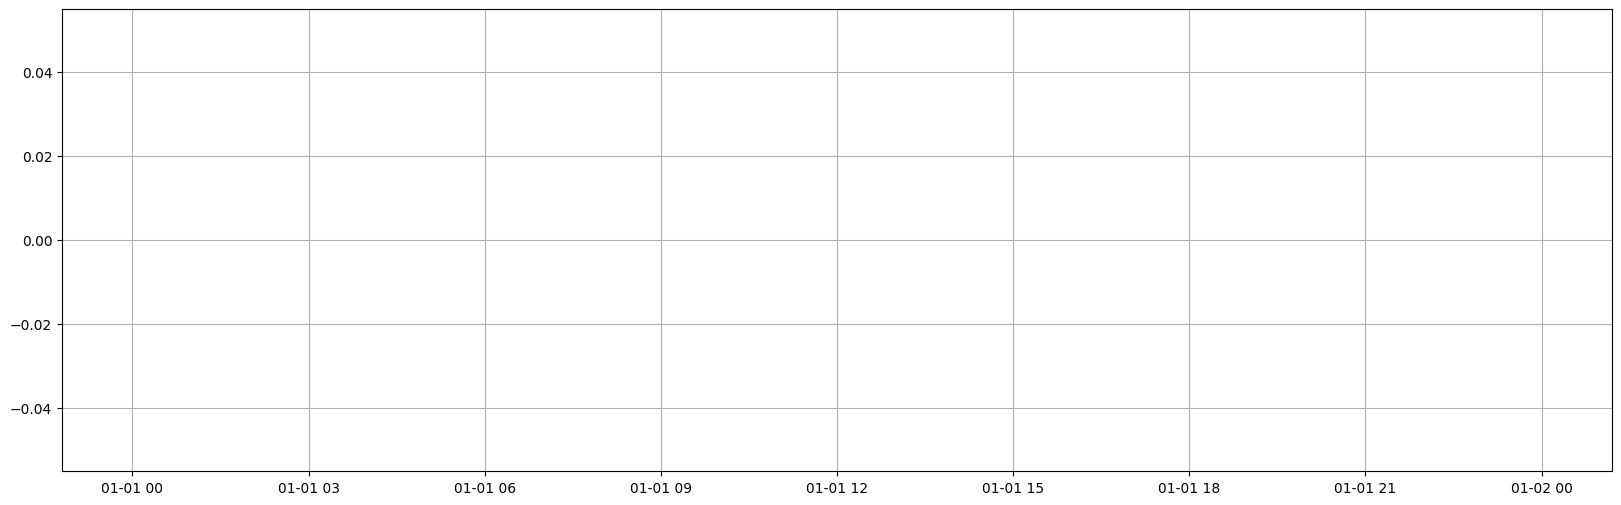

In [48]:
plt.figure(figsize=(20,6))
plt.plot(hsi_rs.index,hsi_rs['bids_0_price_'])
plt.plot(hsi_rs.index,hsi_rs['asks_0_price_'])
plt.grid(True)

In [49]:
iDisp.display(HTML("<H3>Hit - Own PnL by Time of Day</H3>"))

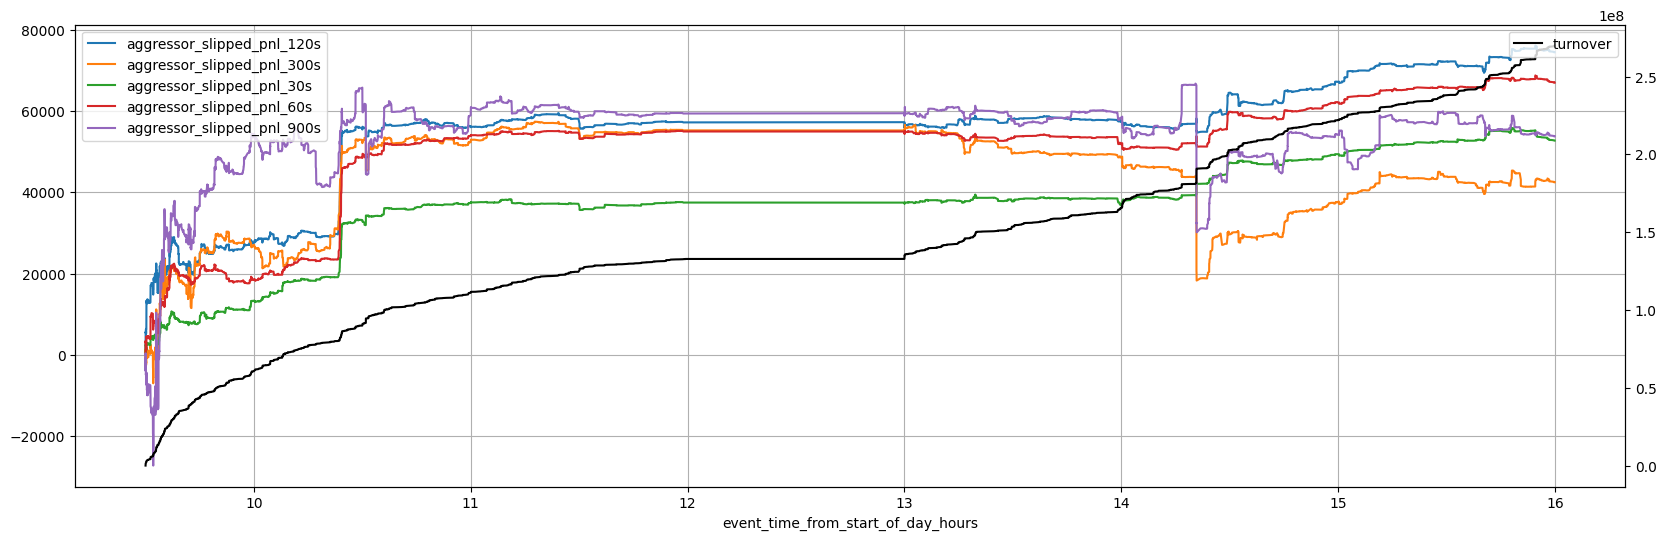

In [50]:
plot(trade_data, index='event_time_from_start_of_day_hours', values=['aggressor_slipped_pnl_30s', 'aggressor_slipped_pnl_60s', 'aggressor_slipped_pnl_120s', 'aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s'], values_right='turnover', 
     filters=(lambda x: (x['aggressive_competitor'] == 'IMC')))

In [51]:
iDisp.display(HTML("<H3>Hit - Citadel PnL by Time of Day</H3>"))

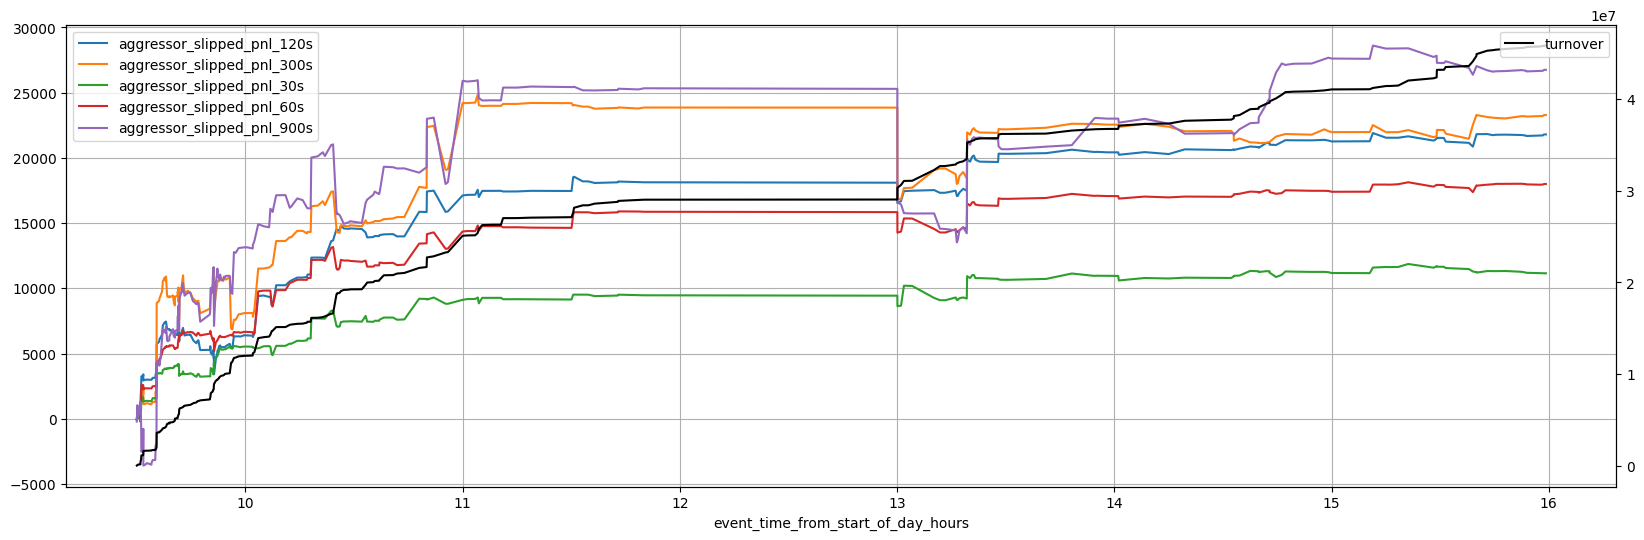

In [52]:
plot(trade_data, index='event_time_from_start_of_day_hours', values=['aggressor_slipped_pnl_30s', 'aggressor_slipped_pnl_60s', 'aggressor_slipped_pnl_120s', 'aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s'], values_right='turnover', 
     filters=(lambda x: (x['aggressive_competitor'] == 'Citadel')))

In [53]:
iDisp.display(HTML("<H3>Hit - Barclays PnL by Time of Day</H3>"))

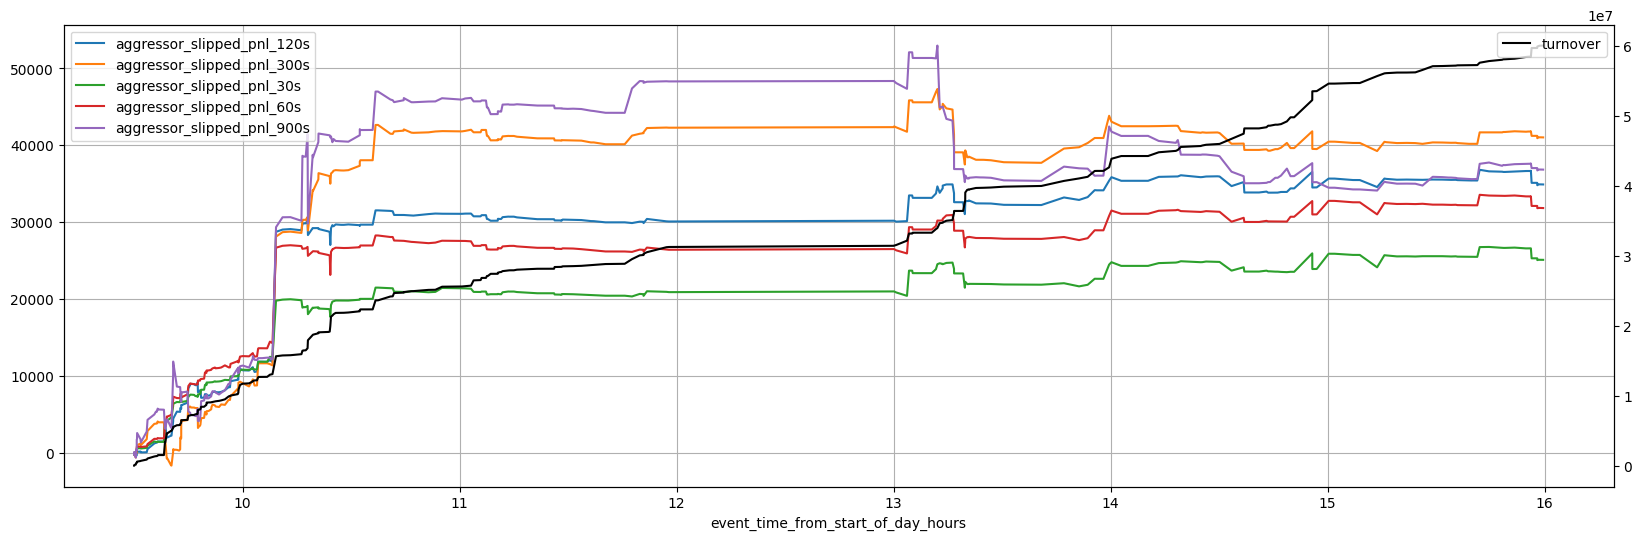

In [54]:
plot(trade_data, index='event_time_from_start_of_day_hours', values=['aggressor_slipped_pnl_30s', 'aggressor_slipped_pnl_60s', 'aggressor_slipped_pnl_120s', 'aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s'], values_right='turnover', 
     filters=(lambda x: (x['aggressive_competitor'] == 'Barclays')))

In [55]:
iDisp.display(HTML("<H3> Citadel PNL for top 5 symbols by time of day</H3>"))

In [56]:
top_5_symbols = trade_data[lambda x: x.aggressive_competitor=='Citadel'].groupby('product_symbol').sum().sort_values('aggressor_slipped_pnl_120s',ascending=False).head(5).index

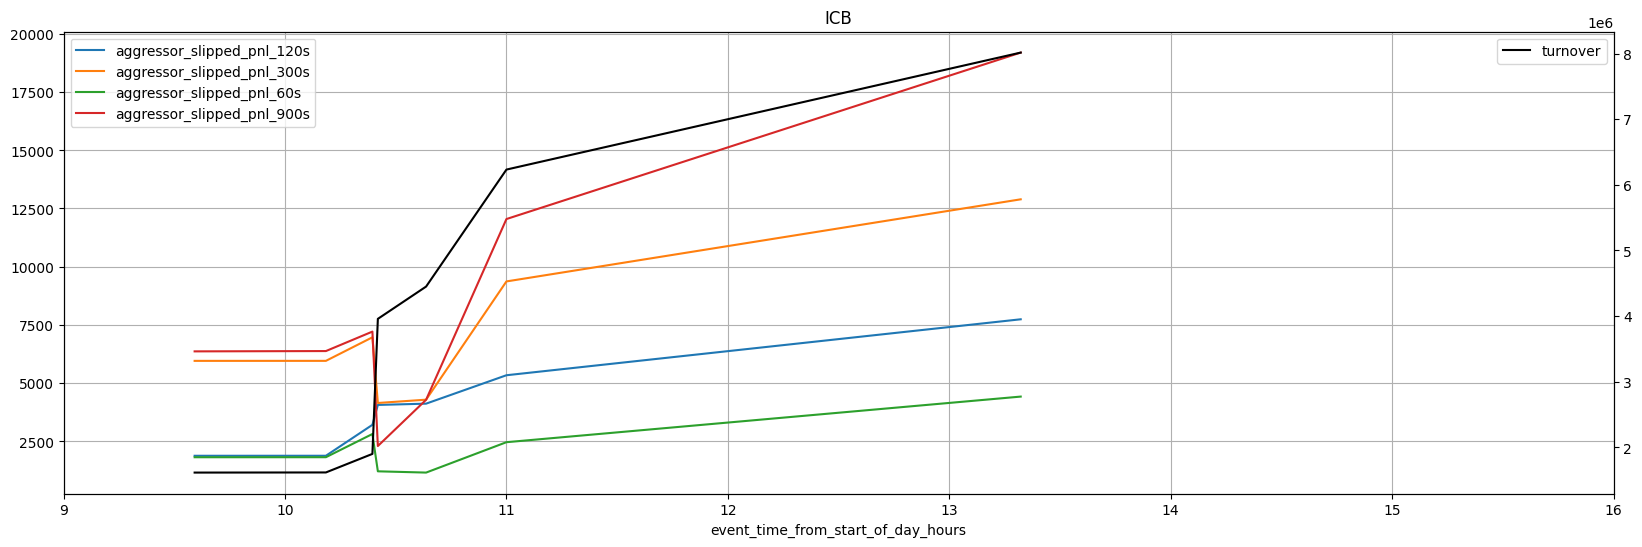

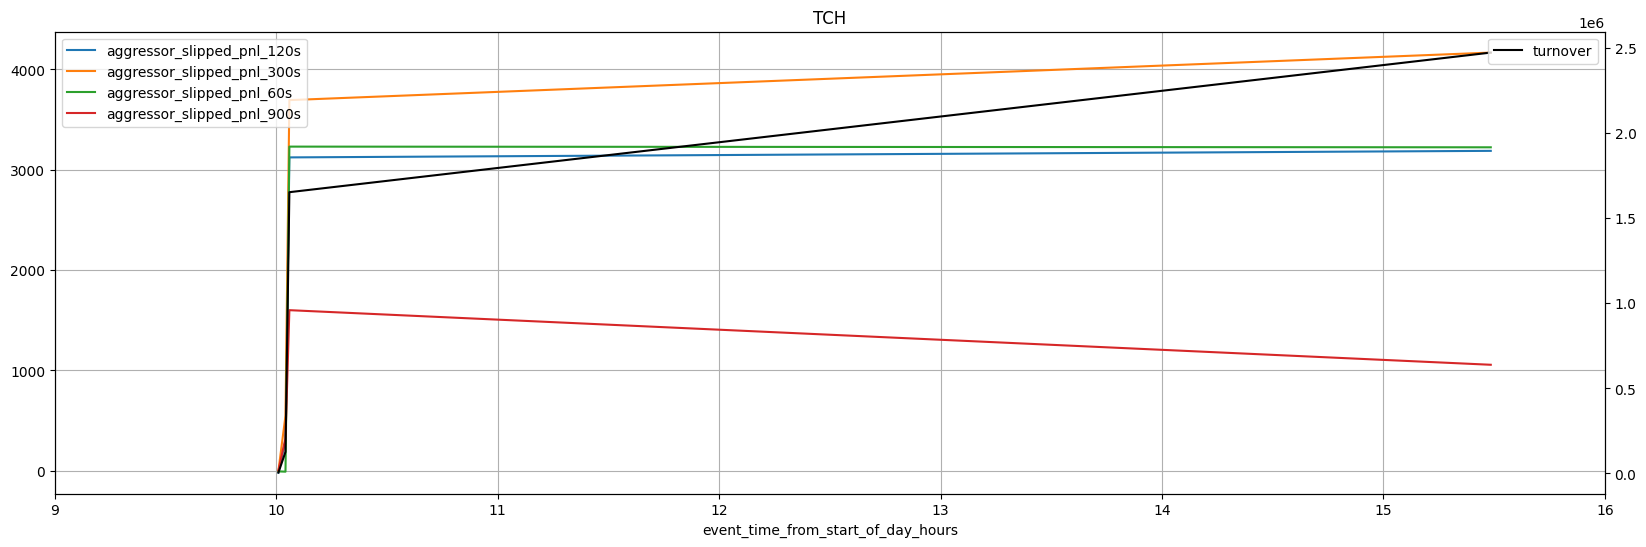

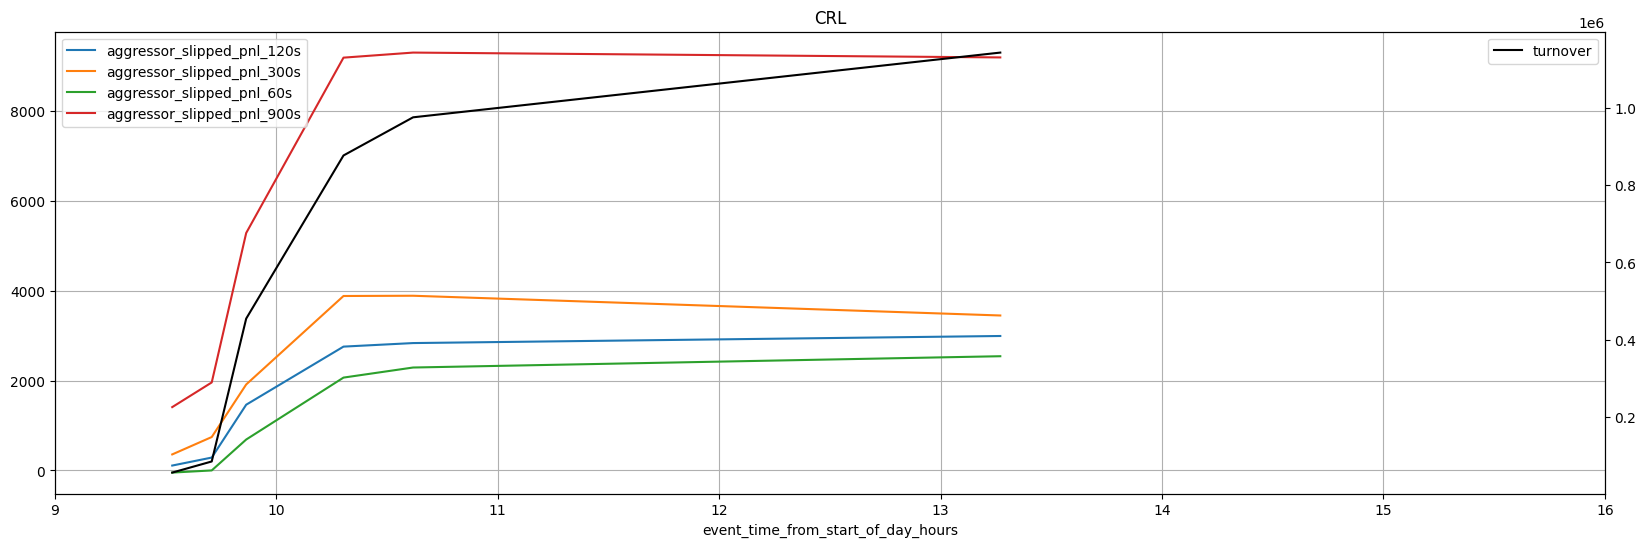

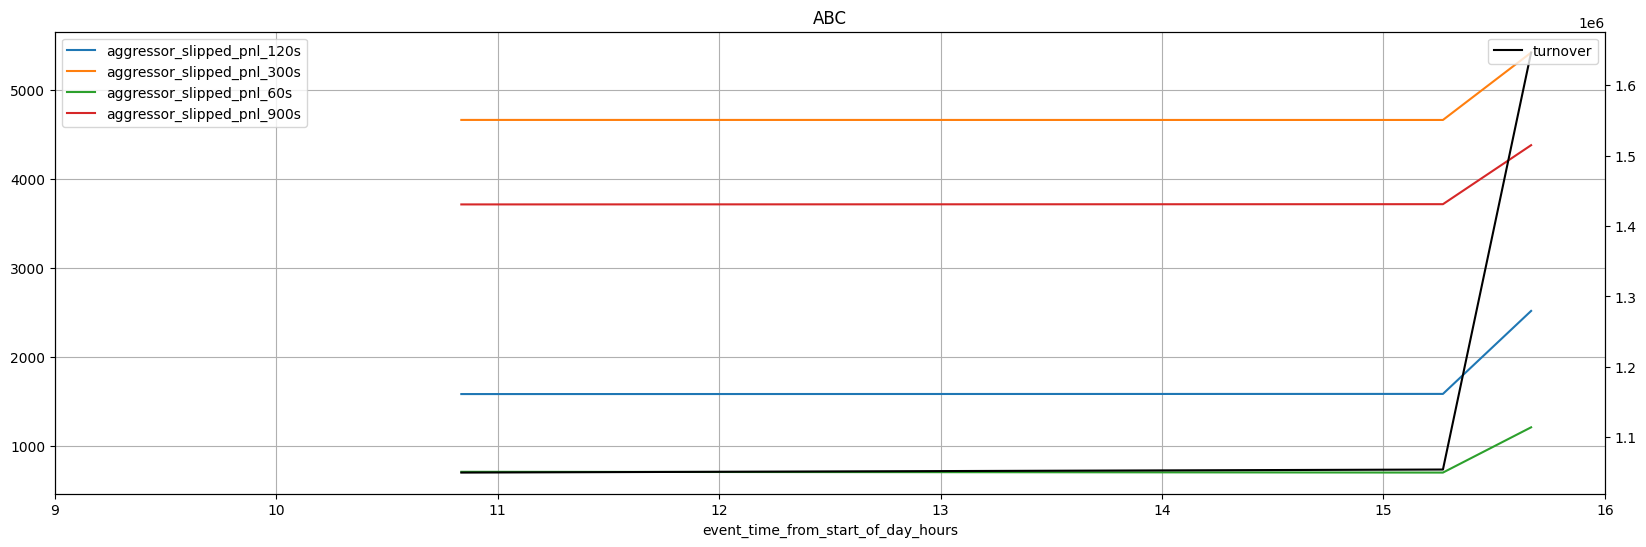

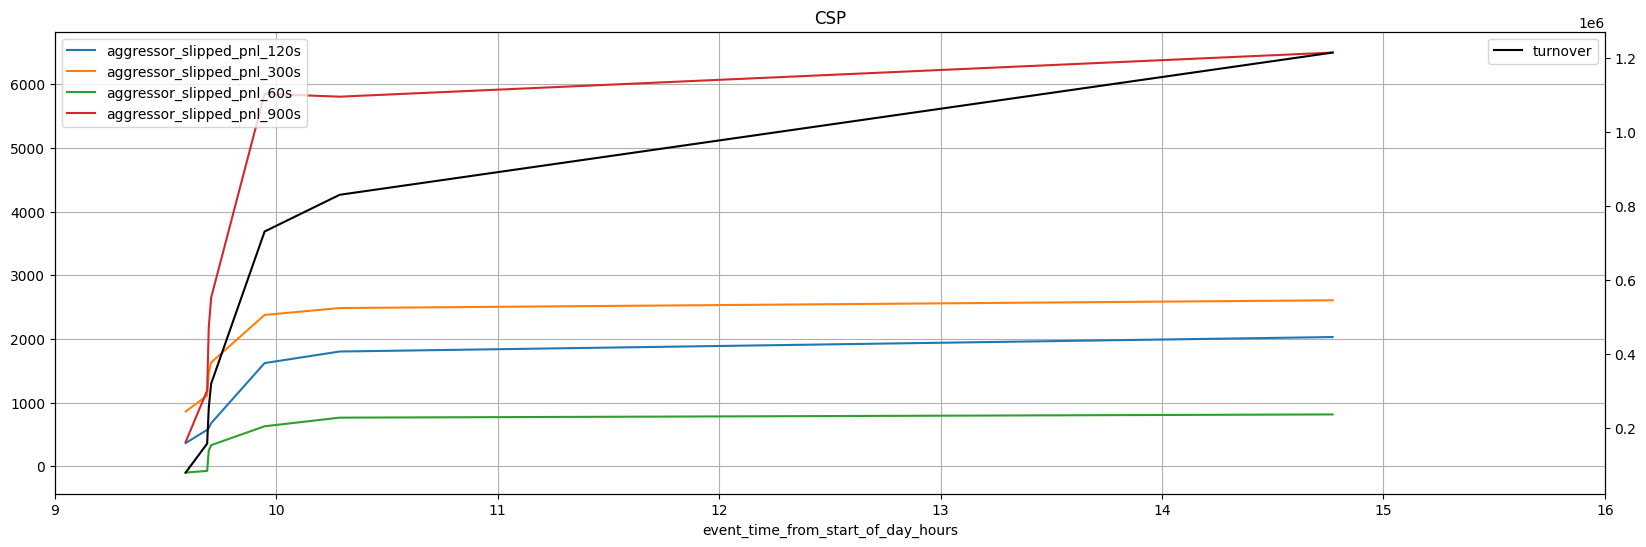

In [57]:
for symbol in top_5_symbols:
    plot(trade_data, index='event_time_from_start_of_day_hours',values=['aggressor_slipped_pnl_60s', 'aggressor_slipped_pnl_120s', 'aggressor_slipped_pnl_300s', 'aggressor_slipped_pnl_900s'], values_right='turnover',
         filters=(lambda x: (x['aggressive_competitor'].isin(['Citadel']))&(x.product_symbol==symbol)),title=symbol,xlim=(9,16))

In [58]:
iDisp.display(HTML("<H3> Citadel top 10 best trades</H3>"))

In [59]:
trade_data[lambda x: x.aggressive_competitor == 'Citadel'].sort_values('aggressor_slipped_pnl_120s').tail(10)[['event_received_datetime','product_symbol','credit_at_max_event_sent_bps','side','join_volume','event_volume','event_price','level_volume_at_event','aggressor_volume','aggressor_level_fraction','aggressor_slipped_pnl_30s','aggressor_slipped_pnl_60s','aggressor_slipped_pnl_120s','aggressor_slipped_pnl_300s']]

,event_received_datetime,product_symbol,credit_at_max_event_sent_bps,side,join_volume,event_volume,event_price,level_volume_at_event,aggressor_volume,aggressor_level_fraction,aggressor_slipped_pnl_30s,aggressor_slipped_pnl_60s,aggressor_slipped_pnl_120s,aggressor_slipped_pnl_300s
241899,2024-01-05 10:50:08.469510,ABC,11.1,ASK,1026000,640000,3.04,1918000,1918000,1,-11.4,241,532,"1,560"
41049,2024-01-05 09:35:30.221609,ICB,8.05,ASK,724000,724000,3.76,2390000,2390000,1,562,554,574,"1,810"
147227,2024-01-05 10:08:30.206244,PEC,6.65,ASK,154000,154000,5.42,410000,410000,1,271,474,597,694
259647,2024-01-05 10:59:59.744350,ICB,11.7,BID,2000000,1582000,3.82,7988000,2591000,0.324,187,799,747,"3,100"
16062,2024-01-05 09:31:16.751976,LAU,9.39,BID,13300,13300,139,16500,16500,1,754,"1,030",768,279
178239,2024-01-05 10:23:40.598194,ICB,10.3,ASK,250000,250000,3.79,5409000,414000,0.0765,365,603,803,612
103233,2024-01-05 09:51:50.850108,CRL,7.28,ASK,68000,68000,27,76000,76000,1,370,617,"1,050","1,050"
375654,2024-01-05 13:19:20.950996,ICB,9.79,BID,3000000,1208000,3.79,8783000,2612000,0.297,796,906,"1,110","1,630"
237662,2024-01-05 10:48:00.241167,CMB,6.16,ASK,100000,65500,27.5,111000,111000,1,944,963,"1,120","1,370"
375653,2024-01-05 13:19:20.950996,ICB,9.79,BID,1252000,1252000,3.79,8783000,2612000,0.297,825,939,"1,150","1,690"


In [60]:
iDisp.display(HTML("<H3> Barclays top 10 best trades</H3>"))

In [61]:
trade_data[lambda x: x.aggressive_competitor == 'Barclays'].sort_values('aggressor_slipped_pnl_120s').tail(10)[['event_received_datetime','product_symbol','credit_at_max_event_sent_bps','side','join_volume','event_volume','event_price','level_volume_at_event','aggressor_volume','aggressor_level_fraction','aggressor_slipped_pnl_30s','aggressor_slipped_pnl_60s','aggressor_slipped_pnl_120s','aggressor_slipped_pnl_300s']]

,event_received_datetime,product_symbol,credit_at_max_event_sent_bps,side,join_volume,event_volume,event_price,level_volume_at_event,aggressor_volume,aggressor_level_fraction,aggressor_slipped_pnl_30s,aggressor_slipped_pnl_60s,aggressor_slipped_pnl_120s,aggressor_slipped_pnl_300s
78467,2024-01-05 09:45:01.110637,GAH,4.6,ASK,200000,200000,8.56,378000,378000,1,299,583,989,914
185119,2024-01-05 10:24:27.035240,ICB,9,ASK,1000000,1000000,3.8,2971000,1996000,0.672,771,"1,510","1,090",669
148858,2024-01-05 10:09:15.017961,CPC,10.2,ASK,234000,234000,4.1,3466000,3466000,1,500,839,"1,140","1,130"
148865,2024-01-05 10:09:15.017961,CPC,10.2,ASK,250000,250000,4.1,3466000,3466000,1,534,896,"1,220","1,210"
148863,2024-01-05 10:09:15.017961,CPC,10.2,ASK,264000,264000,4.1,3466000,3466000,1,564,946,"1,290","1,280"
148859,2024-01-05 10:09:15.017961,CPC,10.2,ASK,338000,276000,4.1,3466000,3466000,1,590,989,"1,350","1,330"
148861,2024-01-05 10:09:15.017961,CPC,10.2,ASK,370000,370000,4.1,3466000,3466000,1,791,"1,330","1,810","1,790"
148867,2024-01-05 10:09:15.017961,CPC,10.2,ASK,400000,400000,4.1,3466000,3466000,1,855,"1,430","1,960","1,930"
148862,2024-01-05 10:09:15.017961,CPC,10.2,ASK,500000,500000,4.1,3466000,3466000,1,"1,070","1,790","2,440","2,420"
148855,2024-01-05 10:09:15.017961,CPC,10.2,ASK,948000,948000,4.1,3466000,3466000,1,"2,030","3,400","4,640","4,590"
